In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='/content/',
                            train=True,
                            download=True,
                            transform=transform)

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
test_data = datasets.MNIST(root='/content/',
                            train=False,
                            download=True,
                            transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=10,shuffle=False)

In [8]:
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [9]:
for i, (X_train,y_train) in enumerate(train_data):
  break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1,1,28,28)

In [12]:
x.shape

torch.Size([1, 1, 28, 28])

In [13]:
x = F.relu(conv1(x))

In [14]:
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
x = F.max_pool2d(x,2,2)

In [16]:
x.shape

torch.Size([1, 6, 13, 13])

In [17]:
x = F.relu(conv2(x))

In [18]:
x.shape

torch.Size([1, 16, 11, 11])

In [19]:
x = F.max_pool2d(x,2,2)

In [20]:
x.shape

torch.Size([1, 16, 5, 5])

In [21]:
x = x.view(-1,16*5*5)

In [22]:
x.shape

torch.Size([1, 400])

In [23]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1   = nn.Linear(5*5*16,120)
    self.fc2   = nn.Linear(120,84)
    self.fc3   = nn.Linear(84,10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,16*5*5)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)     

In [24]:
torch.manual_seed(32)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
sum = 0
for param in model.parameters():
  sum += int(param.numel())
  print(param.numel())
print('Sum:',sum)

54
6
864
16
48000
120
10080
84
840
10
Sum: 60074


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [27]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
          
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.05680715  accuracy:  78.167%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.03596272  accuracy:  85.750%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.77457052  accuracy:  88.872%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.91127408  accuracy:  90.650%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.04931009  accuracy:  91.787%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.04400772  accuracy:  92.631%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.02091801  accuracy:  93.240%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02434590  accuracy:  93.748%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.01395028  accuracy:  94.141%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.71034986  accuracy:  94.497%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00140737  accuracy:  97.667%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00542633  accuracy:  97.658%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.01474824  accuracy:  97.861%
epoch:  1  b

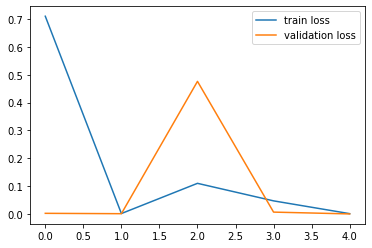

In [28]:
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='validation loss')
plt.legend()

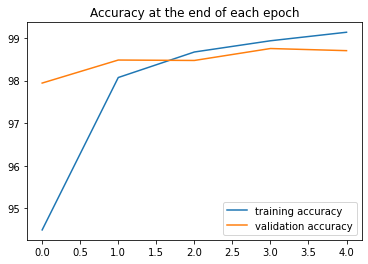

In [29]:
plt.plot([t/600 for t in train_correct],label='training accuracy')
plt.plot([t/100 for t in test_correct],label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [30]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [31]:
with torch.no_grad():
  correct = 0
  for X_test,y_test in test_load_all:
    y_val     = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct  += (predicted==y_test).sum()

In [32]:
correct.item()/len(test_data)

0.987

In [33]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(predicted.view(-1),y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 979    5    1    2    2    2    5    0    4    0]
 [   0 1123    0    0    0    0    3    1    0    1]
 [   0    1 1026    2    0    0    1    4    4    0]
 [   0    0    0  984    0    2    0    0    0    0]
 [   0    0    0    0  973    0    1    0    0    8]
 [   0    1    0   14    0  885    5    0    4    6]
 [   0    1    0    0    1    1  943    0    0    0]
 [   1    3    5    4    2    2    0 1022    3   11]
 [   0    1    0    4    0    0    0    0  956    4]
 [   0    0    0    0    4    0    0    1    3  979]]


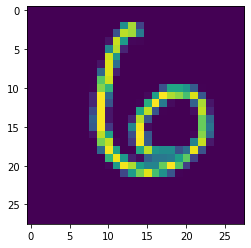

In [37]:
plt.imshow(test_data[100][0].reshape(28,28))

In [38]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[100][0].view(1,1,28,28))

In [39]:
new_prediction

tensor([[-9.1780e+00, -2.0276e+01, -2.6127e+01, -2.9287e+01, -2.0084e+01,
         -9.8114e+00, -1.5818e-04, -3.1703e+01, -1.9755e+01, -2.1161e+01]])

In [40]:
new_prediction.argmax()

tensor(6)